## Intro to IMHOTEP 2
Demo notebook to show how to:
* load data from an ensemble experiment (N members from an ensembme simulation) over a selected region,
* compute a weighted mean over the region,
* Plot timeseries and customize the plot,
* save your selected regional data into a netcdf file for later use
* re-open the above file
* plot timeseries to compare 2 ensemble experiments.

#### Import modules

In [2]:
## standart libraries

import os,sys
import numpy as np

# xarray
import xarray as xr

# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap

import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

import cartopy.feature as cfeature

import cmocean

import pkg_resources


# custom tools for plotting
sys.path.append('./')
from libimhotep import libSLXtoolsIMHOTEP as li
from libimhotep import pltscripts as pltGLO

plt.rcParams.update({'hatch.color': '#086A87'})

# for jupyter notebook display
%matplotlib inline

# Parameters

In [18]:
# EGAI: this is experiment EGAI (ensemble simulation) of which we will load all the 10 members
nexp = "ES"

prefix = "eORCA025.L75-IMHOTEP"

# frequency of the input files
fo="1y"

# name of the variable
varnasss = 'sosaline'

# file type
fileType = "gridTsurf"

# period over which to read
y1='1980'
y2='2018'

# ensemble size
NE=10

# input directory on work for grid info
#diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
dirigrid = '/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/'

# plot directory !!!! CREATE THIS DIRECTORY FIRST ON JEAN ZAY IF DOESNT EXIST YET
diro="/gpfswork/rech/cli/regi915/PLT/2023-05/"+fo+"/"

# data output directory   !!!! CREATE THIS DIRECTORY FIRST ON JEAN ZAY IF DOESNT EXIST YET
dirdat="/gpfswork/rech/cli/regi915/DAT/"



# Load data

* grid file:

_Note: The mask is made of the grid cells that doesnt contain ocean. e1 and e2 are the grid size of the mesh in the x and y direction. You need this when you want to compute a spatial average over a given region so that the variable to average is weighted by the area of each grid cell._

In [19]:
mask = xr.open_dataset(dirigrid+'mesh_hgr.nc')['tmask'][0,0,:,:]
e1    = xr.open_dataset(dirigrid+'mesh_hgr.nc')['e1t'][0,:,:]
e2    = xr.open_dataset(dirigrid+'mesh_hgr.nc')['e2t'][0,:,:]

* load data over selected region (here Bay of Bengale, East of India)

_Note: the `Floadmultimb` function above allows you to load multiple members of the same ensemble at once, for a subregion of which you know the x and y indices_

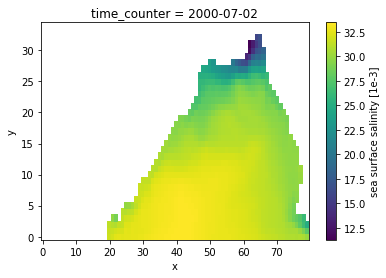

In [24]:
# x and y indices you want to select the region over.
xselect=[10,90]
yselect=[745,780]

regdata = li.Floadmultimb(NE,nexp,prefix,varnasss,fo,fileType,y1,y2,xselect=[10,90],yselect=[745,780],verbose=False)

# quick plot as a check 
regdata.isel(e=0,time_counter=20).plot()

* load grid metrics over selected region

In [21]:
e1s=e1.isel(x=slice(xselect[0],xselect[1]),y=slice(yselect[0],yselect[1]))
e2s=e2.isel(x=slice(xselect[0],xselect[1]),y=slice(yselect[0],yselect[1]))

## SPatial average

* spatial average
(weighted average by the area of the grid cells)

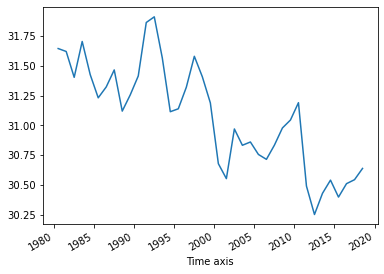

In [22]:
# compute weighted average in ocean grid cells only (and keep value zero where there is no ocean)
bobSMEAN = li.FcomputeGM(regdata.where(regdata>0),e1s.where(regdata>0),e2s.where(regdata>0))
bobSMEAN  = bobSMEAN.compute()

# quick plot as a check
bobSMEAN.isel(e=0).plot()

# Compute ensemble mean and ensemble std 

In [29]:
# compute ensemble mean and ensemble std from exp1
em   = bobSMEAN.mean(dim='e')
estd = bobSMEAN.std(dim='e') 
estdMAX = em+2*estd
estdMIN = em-2*estd


# Customized plot

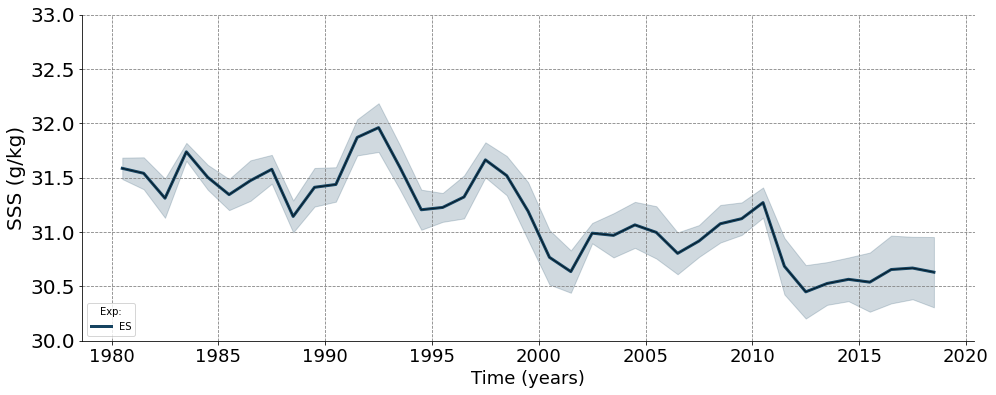

In [30]:
namo="ts-SPMEAN_indo"+"_"+nexp
gp = 0
NGP=5

#-------------
# start plot by creating an empty figure
fig1 = plt.figure(figsize=([16,6]),facecolor='white')  

#-------------
# plot 
# color 1 (pick your own html code from https://htmlcolorcodes.com/)
c1="#154360"

# defined label top appear on plot
la=nexp

# plot shading between lines for ensemble mean - 2x ensemble std and ensemble mean + 2x ensemble std
plt.fill_between(em.time_counter,estdMIN,estdMAX,color=c1,alpha=0.2, label='' )

# plot ensemble mean
bobSMEAN.mean(dim='e').squeeze().plot(linewidth=3,color=c1,label=la)
bobSMEAN.mean(dim='e').squeeze().plot(linewidth=0.5,color='k')
 

#-------------
# now customize plot
ax = plt.gca()    

# plot grid
ax.grid(which='both', color='grey', linestyle='--')

# Choose which  lines of the plot frame will appear. 
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(True)  

# axis label size
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(18)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=20)

# decide if axis ticks are inside or outside plot frame
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')

# rotate ticks with an angle
plt.xticks(rotation=0, ha='center',va="top")

# axis labels
plt.xlabel("Time (years)")
plt.ylabel("SSS (g/kg)")

# add legend and choose where it will appear
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Exp:', loc='lower left')

# set the limits of the plot on y axis
plt.ylim(30,33)

# empty plot title
plt.title('')

# display plot in notebook window
plt.show()

#--------------------
# Save fig in png, resolution dpi    
li.Fsaveplt(fig1,diro,namo,dpifig=300)

# Save your regional data in netcdf file for later use

In [31]:
# name of the file to create
filo="bob_spmean_"+nexp+"_"+fo+".nc"

# add some information to the file
bobSMEAN.name = 'bobSPMEAN'
bobSMEAN.attrs['long_name']='bobSPMEAN'
bobSMEAN.attrs['standard_name']='bobSPMEAN'
bobSMEAN.attrs['exp']=nexp

# write file 
bobSMEAN.to_netcdf(path=diro+filo,mode='w')

# You can re-do the above for another ensemble experiment. 
For example, do the above for EGAI first, then for ES.

---
# Once you have computed and save your regional data in a file the spatial average of 2 experiments:

_Note: once you have saved the above files, you don't need to re-do these above steps each time. You can just start the notebook here by loading the regional data from your saved files._

* reload data from files

In [32]:
filo0="bob_spmean_EGAI_"+fo+".nc"
filo2="bob_spmean_ES_"+fo+".nc"

readbobSMEAN = xr.open_dataset(diro+filo0,decode_times=True)['bobSPMEAN']
readbobSMEAN
readbobSMEAN2 = xr.open_dataset(diro+filo2,decode_times=True)['bobSPMEAN']
readbobSMEAN2

<xarray.DataArray 'bobSPMEAN' (e: 10, time_counter: 39)>
array([[31.645579, 31.62093 , 31.403927, ..., 30.511332, 30.544744, 30.639241],
       [31.593363, 31.541755, 31.277862, ..., 30.776344, 30.742979, 30.687991],
       [31.56011 , 31.5464  , 31.347138, ..., 30.520614, 30.415486, 30.411256],
       ...,
       [31.622583, 31.603176, 31.272462, ..., 30.841539, 30.887632, 30.658719],
       [31.666996, 31.650661, 31.50686 , ..., 30.55804 , 30.625134, 30.529901],
       [31.560886, 31.520323, 31.291325, ..., 30.764907, 30.732276, 30.612372]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-07-02 ... 2018-07-02T12:...
Dimensions without coordinates: e
Attributes:
    long_name:      bobSPMEAN
    standard_name:  bobSPMEAN
    exp:            ES

* plot both experiments:

# Plot ensembmle mean evolution (and spread around ensemble mean)

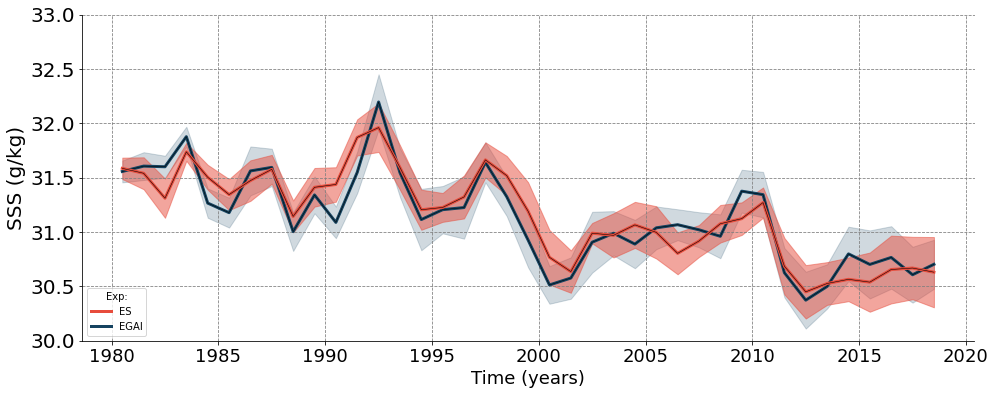

In [33]:
namo="ts-SPMEAN_indo"+"_"+nexp
gp = 0
NGP=5

#-------------
# start plot 
fig1 = plt.figure(figsize=([16,6]),facecolor='white')  

#-------------
# ensemble mean and ensemble std from exp1
em   = readbobSMEAN.mean(dim='e')
estd = readbobSMEAN.std(dim='e') 
estdMAX = em+2*estd
estdMIN = em-2*estd

#-------------
# ensemble mean and ensemble std from exp1
em2   = readbobSMEAN2.mean(dim='e')
estd2 = readbobSMEAN2.std(dim='e') 
estdMAX2 = em2+2*estd2
estdMIN2 = em2-2*estd2

#-------------
# plot exp1
c1="#154360"
plt.fill_between(em.time_counter,estdMIN,estdMAX,color=c1,alpha=0.2, label='' )
la='EGAI'
readbobSMEAN.mean(dim='e').squeeze().plot(linewidth=3,color=c1,label=la)
readbobSMEAN.mean(dim='e').squeeze().plot(linewidth=0.5,color='k')
 
#------------ 
# plot exp2
c2= "#e74c3c"
plt.fill_between(em2.time_counter,estdMIN2,estdMAX2,color=c2,alpha=0.5, label='' )
#for ie in range(0,readbobSMEAN2.e.size):
#        la = ''
#        readbobSMEAN2.isel(e=ie).squeeze().plot(linewidth=0.5,color=color_list[4],label=la)
la='ES'
readbobSMEAN2.mean(dim='e').squeeze().plot(linewidth=3,color=c2,label=la)
readbobSMEAN2.mean(dim='e').squeeze().plot(linewidth=0.5,color='k')

#-------------
# customize plot
ax = plt.gca()    

ax.grid(which='both', color='grey', linestyle='--')
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(True)  

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(18)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=20)

ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')


plt.xticks(rotation=0, ha='center',va="top")
plt.xlabel("Time (years)")
plt.ylabel("SSS (g/kg)")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Exp:', loc='lower left')

#plt.legend()
plt.ylim(30,33)
plt.title('')
plt.show()

#--------------------
# Save fig in png, resolution dpi    
li.Fsaveplt(fig1,diro,namo,dpifig=300)

# Plot difference of the ensemble mean of the 2 experiments and the growth of their spread with time

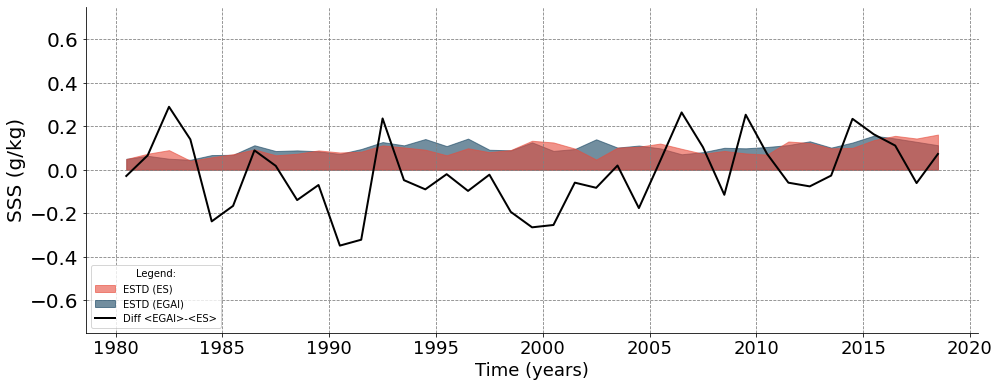

In [34]:
namo="tsdiff-SPMEAN_indo"+"_"+nexp
gp = 0
NGP=5

diff = readbobSMEAN.mean(dim='e') - readbobSMEAN2.mean(dim='e')
estd = readbobSMEAN.std(dim='e') 
estd2 = readbobSMEAN2.std(dim='e') 

# create a color_list of NP different colors
cmap = cm.get_cmap('Spectral', NGP)
color_list = [mcolors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
#color_list = color_list[1:]+['gray']

# plot timeseries
fig1 = plt.figure(figsize=([16,6]),facecolor='white')  



diff.squeeze().plot(linewidth=2,color='k',label='Diff <EGAI>-<ES>')

plt.fill_between(estd.time_counter,0*estd,estd,color=c1,alpha=0.6, label='ESTD (EGAI)' )
plt.fill_between(estd2.time_counter,0*estd2,estd2,color=c2,alpha=0.6, label='ESTD (ES)')


ax = plt.gca()    

ax.grid(which='both', color='grey', linestyle='--')
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(True)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(True)  

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(18)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=20)

ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')


plt.xticks(rotation=0, ha='center',va="top")
plt.xlabel("Time (years)")
plt.ylabel("SSS (g/kg)")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Legend:', loc='lower left')

#plt.legend()
plt.ylim(-0.75,0.75)
plt.title('')
plt.show()

# Save fig in png, resolution dpi    
li.Fsaveplt(fig1,diro,namo,dpifig=300)